In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, precision_recall_curve, auc

# Pre-process dataset

In [9]:
df = pd.read_csv('../00_dataset/YelpZip/metadata', 
                 sep='\t',
                 header=None,
                 names=["user_id", "prod_id", "rating", "label", "date"])
df

,user_id,prod_id,rating,label,date
0,5044,0,1.0,-1,2014-11-16
1,5045,0,1.0,-1,2014-09-08
2,5046,0,3.0,-1,2013-10-06
3,5047,0,5.0,-1,2014-11-30
4,5048,0,5.0,-1,2014-08-28
...,...,...,...,...,...
608593,119664,5039,4.0,1,2013-01-20
608594,56277,5039,2.0,1,2012-11-12
608595,265320,5039,1.0,1,2012-08-22
608596,161722,5039,4.0,1,2011-05-11


In [10]:
# Check for Null values
df.isnull().sum()

user_id    0
prod_id    0
rating     0
label      0
date       0
dtype: int64

In [11]:
# Equalise 1 and -1 labels, only 8000 rows per label
# positive_df = df[(df['label'] == 1)][:8000]
# negative_df = df[(df['label'] == -1)][:8000]
positive_df = df[(df['label'] == 1)]
negative_df = df[(df['label'] == -1)]
negative_df["label"] = 0
dataset_df = pd.concat([positive_df, negative_df])
dataset_df

C:\Users\cryst\AppData\Local\Temp\ipykernel_44660\2848714389.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df["label"] = 0


,user_id,prod_id,rating,label,date
7,5051,0,1.0,1,2014-12-05
8,5052,0,2.0,1,2014-11-26
9,5053,0,4.0,1,2014-11-17
10,5054,0,3.0,1,2014-10-20
11,5055,0,5.0,1,2014-10-13
...,...,...,...,...,...
608583,265316,5042,5.0,0,2014-12-24
608586,247830,5039,3.0,0,2011-12-03
608587,265318,5039,4.0,0,2015-01-02
608588,100625,5039,4.0,0,2013-11-02


# Create Train-test split

In [12]:
y = dataset_df['label']
X = dataset_df.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)

# Without Feature Engineering

Accuracy: 0.6113
Precision: 0.9042
Recall: 0.6175
F1 Score: 0.7338

Confusion Matrix:
[[ 32134  24192]
 [141406 228287]]

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.57      0.28     56326
           1       0.90      0.62      0.73    369693

    accuracy                           0.61    426019
   macro avg       0.54      0.59      0.51    426019
weighted avg       0.81      0.61      0.67    426019

Balanced Accuracy: 0.594
Matthews Correlation Coefficient: 0.130
PR-AUC for class 0: 0.815
PR-AUC for class 1: 0.907


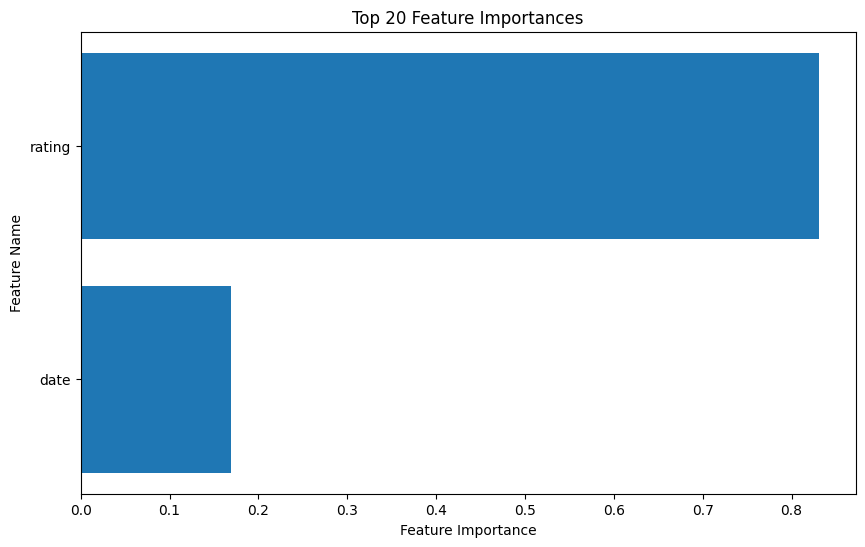

,Feature,Importance
0,rating,0.83056
1,date,0.16944


In [34]:
noFE_train, noFE_test = X_train.copy(), X_test.copy()
noFE_train['date'] = pd.to_datetime(noFE_train['date']).astype('int64') // 10**9
noFE_test['date'] = pd.to_datetime(noFE_test['date']).astype('int64') // 10**9

noFE_train = noFE_train.drop(columns=["user_id", "prod_id"])
noFE_test = noFE_test.drop(columns=["user_id", "prod_id"])

temp = noFE_train.copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

noFE_train = scaler.fit_transform(noFE_train)
noFE_test = scaler.transform(noFE_test)


from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


xgclf = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
xgclf.fit(noFE_train, y_train)
y_pred = xgclf.predict(noFE_test)
# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'weighted' for multiclass
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

"""
OTHER METRICS
"""
# Balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# MCC
mcc = matthews_corrcoef(y_test, y_pred)

# PR-AUC
y_pred_proba = xgclf.predict_proba(noFE_test)

# For PR-AUC for class 0 (negative class)
precision_0, recall_0, _ = precision_recall_curve(y_test, y_pred_proba[:, 0])  # Use first column for class 0
pr_auc_0 = auc(recall_0, precision_0)

# For PR-AUC for class 1 (positive class)
precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])  # Use second column for class 1
pr_auc_1 = auc(recall_1, precision_1)


print(f"Balanced Accuracy: {balanced_acc:.3f}")
print(f"Matthews Correlation Coefficient: {mcc:.3f}")
print(f"PR-AUC for class 0: {pr_auc_0:.3f}")
print(f"PR-AUC for class 1: {pr_auc_1:.3f}")

import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Train XGBoost model
xgclf = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
xgclf.fit(noFE_train, y_train)

# Get feature importance
feature_importance = xgclf.feature_importances_
feature_names = temp.columns

# Convert to DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:20], feat_imp_df['Importance'][:20])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Display the top features
feat_imp_df.head()

# Import Feature Engineer functions

In [14]:
from UserFeatureEngineering import UserEngineer
from RestaurantFeatureEngineering import RestaurantEngineer

userFeatureEngineer = UserEngineer(X_train)
restaurantFeatureEngineer = RestaurantEngineer(X_train)

# Apply feature engineering to train set

In [15]:
# Create the features and merge them with original dataset
user_features_train = userFeatureEngineer.aggregateTrainFeatures()
res_features_train = restaurantFeatureEngineer.aggregateTrainFeatures()

new_X_train = X_train.merge(res_features_train, on='prod_id', how='left').merge(user_features_train, on='user_id', how='left')

# Convert date to seconds
new_X_train['date'] = pd.to_datetime(new_X_train['date']).astype('int64') // 10**9

new_X_train

,user_id,prod_id,rating,date,total_reviews_for_restaurant,avg_rating_for_restaurant,std_dev_rating_for_restaurant,median_rating_for_restaurant,review_frequency_for_restaurant,extreme_rating_index,...,rating_mean,rating_min,rating_max,rating_std,user_earliest,user_latest,user_days_active,user_review_timespan,users_avg_per_day,user_active_percentage
0,52463,4438,5.0,1270598400,9,4.444444,1.130388,5.0,173.000000,1.666667,...,3.500,2.0,5.0,2.121,1270252800,1270598400,2,4,0.500,0.500
1,30414,4304,4.0,1403481600,59,3.966102,0.850276,4.0,3.847458,1.101695,...,3.765,3.0,5.0,0.664,1322438400,1415059200,12,1072,0.016,0.011
2,44884,456,4.0,1322956800,68,4.397059,0.916510,5.0,32.367647,1.573529,...,4.000,4.0,4.0,0.000,1322956800,1322956800,1,1,1.000,1.000
3,184664,3080,4.0,1412208000,76,3.934211,1.099521,4.0,6.184211,1.223684,...,4.000,4.0,4.0,0.000,1412208000,1412208000,1,1,1.000,1.000
4,65199,3702,3.0,1386892800,192,4.015625,1.177790,4.0,5.890625,1.401042,...,3.571,2.0,5.0,1.134,1283385600,1389484800,6,1228,0.006,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182574,101118,2052,5.0,1399075200,113,4.203540,0.846835,4.0,25.796460,1.309735,...,3.000,1.0,5.0,2.828,1399075200,1416528000,2,202,0.010,0.010
182575,254535,4743,3.0,1409097600,279,3.695341,1.221957,4.0,11.645161,1.211470,...,3.000,3.0,3.0,0.000,1409097600,1409097600,1,1,1.000,1.000
182576,183926,3057,4.0,1314316800,22,3.500000,1.371478,4.0,115.181818,1.318182,...,4.000,4.0,4.0,0.000,1314316800,1314316800,1,1,1.000,1.000
182577,68150,828,3.0,1407888000,929,3.730893,1.166488,4.0,1.710441,1.180840,...,3.000,3.0,3.0,0.000,1407888000,1407888000,1,1,1.000,1.000


# Apply SMOTE to balance dataset

In [16]:
# #TODO think of another way to balance dataset
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(sampling_strategy='auto', random_state=42)
# new_X_train, y_train = smote.fit_resample(new_X_train, y_train)

# Apply feature engineering to test set
### ...sequentially

In [17]:
new_X_test = restaurantFeatureEngineer.updateTestRestaurants(X_test)
new_X_test = userFeatureEngineer.updateTestUsers(new_X_test)
new_X_test

,user_id,prod_id,rating,date,total_reviews_for_restaurant,avg_rating_for_restaurant,std_dev_rating_for_restaurant,median_rating_for_restaurant,review_frequency_for_restaurant,extreme_rating_index,...,rating_mean,rating_min,rating_max,rating_std,user_earliest,user_latest,user_days_active,user_review_timespan,users_avg_per_day,user_active_percentage
0,67202,4076,3.0,1300320000,283,4.194346,0.863588,4.0,10.731449,1.300353,...,3.667,3.0,4.0,0.577,1299974400,1300320000,3,4,0.750,0.750
1,54375,1487,2.0,1342656000,1,5.000000,0.000000,5.0,0.000000,2.000000,...,3.500,3.0,4.0,0.707,1325980800,1345420800,2,225,0.009,0.009
2,56987,4083,4.0,1316217600,691,4.001447,1.022216,4.0,2.594790,1.259045,...,4.375,4.0,5.0,0.518,1298160000,1332115200,7,393,0.020,0.018
3,16001,4034,3.0,1168992000,537,4.050279,0.990291,4.0,6.459963,1.266294,...,3.000,2.0,4.0,1.414,1179705600,1351814400,2,1992,0.001,0.001
4,28187,999,5.0,1417564800,10,4.700000,0.483046,5.0,81.600000,1.700000,...,1.000,1.0,1.0,0.000,1417564800,1417564800,1,1,1.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426014,10701,2879,3.0,1388620800,258,3.100775,1.348554,3.0,7.728682,1.116279,...,3.909,2.0,5.0,1.044,1357689600,1402358400,9,517,0.021,0.017
426015,37874,357,4.0,1291420800,275,3.952727,0.978576,4.0,11.905455,1.207273,...,3.000,3.0,3.0,0.000,1291420800,1291420800,0,1,0.000,0.000
426016,160450,2508,5.0,1344902400,169,4.023669,0.899422,4.0,9.360947,1.201183,...,3.000,3.0,3.0,0.000,1344902400,1344902400,0,1,0.000,0.000
426017,259333,3951,5.0,1408924800,76,4.276316,0.960537,5.0,18.368421,1.434211,...,3.000,3.0,3.0,0.000,1408924800,1408924800,0,1,0.000,0.000


In [18]:
new_X_train = new_X_train.drop(columns=["user_id", "prod_id"], errors="ignore")
new_X_test = new_X_test.drop(columns=["user_id", "prod_id"], errors="ignore")

print(new_X_train.shape, new_X_test.shape)

(182579, 19) (426019, 19)


In [19]:
new_X_train.dtypes

rating                             float64
date                                 int64
total_reviews_for_restaurant         int64
avg_rating_for_restaurant          float64
std_dev_rating_for_restaurant      float64
median_rating_for_restaurant       float64
review_frequency_for_restaurant    float64
extreme_rating_index               float64
user_restaurants_reviewed            int64
rating_mean                        float64
rating_min                         float64
rating_max                         float64
rating_std                         float64
user_earliest                        int64
user_latest                          int64
user_days_active                     int64
user_review_timespan                 int64
users_avg_per_day                  float64
user_active_percentage             float64
dtype: object

In [20]:
new_X_test.dtypes

rating                             float64
date                                 int64
total_reviews_for_restaurant         int32
avg_rating_for_restaurant          float64
std_dev_rating_for_restaurant      float64
median_rating_for_restaurant       float64
review_frequency_for_restaurant    float64
extreme_rating_index               float64
user_restaurants_reviewed            int32
rating_mean                        float64
rating_min                         float64
rating_max                         float64
rating_std                         float64
user_earliest                        int32
user_latest                          int32
user_days_active                     int32
user_review_timespan                 int32
users_avg_per_day                  float64
user_active_percentage             float64
dtype: object

In [21]:
new_X_train.isnull().sum()

rating                             0
date                               0
total_reviews_for_restaurant       0
avg_rating_for_restaurant          0
std_dev_rating_for_restaurant      0
median_rating_for_restaurant       0
review_frequency_for_restaurant    0
extreme_rating_index               0
user_restaurants_reviewed          0
rating_mean                        0
rating_min                         0
rating_max                         0
rating_std                         0
user_earliest                      0
user_latest                        0
user_days_active                   0
user_review_timespan               0
users_avg_per_day                  0
user_active_percentage             0
dtype: int64

In [22]:
new_X_test.isnull().sum()

rating                             0
date                               0
total_reviews_for_restaurant       0
avg_rating_for_restaurant          0
std_dev_rating_for_restaurant      0
median_rating_for_restaurant       0
review_frequency_for_restaurant    0
extreme_rating_index               0
user_restaurants_reviewed          0
rating_mean                        0
rating_min                         0
rating_max                         0
rating_std                         0
user_earliest                      0
user_latest                        0
user_days_active                   0
user_review_timespan               0
users_avg_per_day                  0
user_active_percentage             0
dtype: int64

# Feature Scaling (StandardScaler)

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

new_X_train = pd.DataFrame(scaler.fit_transform(new_X_train), columns=new_X_train.columns)
new_X_test = pd.DataFrame(scaler.transform(new_X_test), columns=new_X_test.columns)


# PCA

In [24]:
#TODO
from sklearn.decomposition import PCA

# pca = PCA(n_components=11)
# new_X_train = pca.fit_transform(new_X_train)
# new_X_test = pca.transform(new_X_test)

# Train model
**Balanced Accuracy** is the average of sensitivity (recall) and specificity. It's used to evaluate models when the dataset is imbalanced, as it provides a more balanced measure of the model's performance across both classes.\
\
**Matthews Corelation Coefficient (MCC)**: is a measure of the quality of binary (two-class) classifications. Unlike accuracy, precision, or recall, it considers all four quadrants of the confusion matrix. \
1 indicates perfect prediction.
0 indicates random prediction.
-1 indicates total disagreement between prediction and truth (e.g., if the model predicts everything wrong).\
\
**PR-AUC** is the area under the Precision-Recall curve, which plots Precision (positive predictive value) vs Recall (sensitivity) for different thresholds of classification.\
1 indicates perfect precision and recall.
0 indicates no precision or recall (i.e., the model is performing terribly).

In [25]:
# LOGISTIC REGRESSION MODEL
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(new_X_train, y_train)

# Make predictions
y_pred = clf.predict(new_X_test)

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'weighted' for multiclass
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print("\nConfusion Matrix:")
# print(conf_matrix)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

"""
OTHER METRICS
"""
# Balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# MCC
mcc = matthews_corrcoef(y_test, y_pred)

# PR-AUC
y_pred_proba = clf.predict_proba(new_X_test)

# For PR-AUC for class 0 (negative class)
precision_0, recall_0, _ = precision_recall_curve(y_test, y_pred_proba[:, 0])  # Use first column for class 0
pr_auc_0 = auc(recall_0, precision_0)

# For PR-AUC for class 1 (positive class)
precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])  # Use second column for class 1
pr_auc_1 = auc(recall_1, precision_1)


print(f"Balanced Accuracy: {balanced_acc:.3f}")
print(f"Matthews Correlation Coefficient: {mcc:.3f}")
print(f"PR-AUC for class 0: {pr_auc_0:.3f}")
print(f"PR-AUC for class 1: {pr_auc_1:.3f}")

Accuracy: 0.8669

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.00      0.01     56326
           1       0.87      1.00      0.93    369693

    accuracy                           0.87    426019
   macro avg       0.58      0.50      0.47    426019
weighted avg       0.79      0.87      0.81    426019

Balanced Accuracy: 0.502
Matthews Correlation Coefficient: 0.022
PR-AUC for class 0: 0.817
PR-AUC for class 1: 0.941


In [26]:
# RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier

rfclf = RandomForestClassifier(class_weight="balanced", random_state=42)
rfclf.fit(new_X_train, y_train)
y_pred = rfclf.predict(new_X_test)

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'weighted' for multiclass
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print("\nConfusion Matrix:")
# print(conf_matrix)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

"""
OTHER METRICS
"""
# Balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# MCC
mcc = matthews_corrcoef(y_test, y_pred)

# PR-AUC
y_pred_proba = rfclf.predict_proba(new_X_test)

# For PR-AUC for class 0 (negative class)
precision_0, recall_0, _ = precision_recall_curve(y_test, y_pred_proba[:, 0])  # Use first column for class 0
pr_auc_0 = auc(recall_0, precision_0)

# For PR-AUC for class 1 (positive class)
precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])  # Use second column for class 1
pr_auc_1 = auc(recall_1, precision_1)


print(f"Balanced Accuracy: {balanced_acc:.3f}")
print(f"Matthews Correlation Coefficient: {mcc:.3f}")
print(f"PR-AUC for class 0: {pr_auc_0:.3f}")
print(f"PR-AUC for class 1: {pr_auc_1:.3f}")

Accuracy: 0.8670

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.03      0.06     56326
           1       0.87      0.99      0.93    369693

    accuracy                           0.87    426019
   macro avg       0.66      0.51      0.50    426019
weighted avg       0.82      0.87      0.81    426019

Balanced Accuracy: 0.514
Matthews Correlation Coefficient: 0.095
PR-AUC for class 0: 0.790
PR-AUC for class 1: 0.952


In [27]:
!pip install xgboost


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
# XGBOOST
from xgboost import XGBClassifier

xgclf = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
xgclf.fit(new_X_train, y_train)
y_pred = xgclf.predict(new_X_test)
# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'weighted' for multiclass
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print("\nConfusion Matrix:")
# print(conf_matrix)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

"""
OTHER METRICS
"""
# Balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)

# MCC
mcc = matthews_corrcoef(y_test, y_pred)

# PR-AUC
y_pred_proba = xgclf.predict_proba(new_X_test)

# For PR-AUC for class 0 (negative class)
precision_0, recall_0, _ = precision_recall_curve(y_test, y_pred_proba[:, 0])  # Use first column for class 0
pr_auc_0 = auc(recall_0, precision_0)

# For PR-AUC for class 1 (positive class)
precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])  # Use second column for class 1
pr_auc_1 = auc(recall_1, precision_1)


print(f"Balanced Accuracy: {balanced_acc:.3f}")
print(f"Matthews Correlation Coefficient: {mcc:.3f}")
print(f"PR-AUC for class 0: {pr_auc_0:.3f}")
print(f"PR-AUC for class 1: {pr_auc_1:.3f}")

Accuracy: 0.7150

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.47      0.30     56326
           1       0.90      0.75      0.82    369693

    accuracy                           0.72    426019
   macro avg       0.56      0.61      0.56    426019
weighted avg       0.81      0.72      0.75    426019

Balanced Accuracy: 0.609
Matthews Correlation Coefficient: 0.166
PR-AUC for class 0: 0.799
PR-AUC for class 1: 0.947


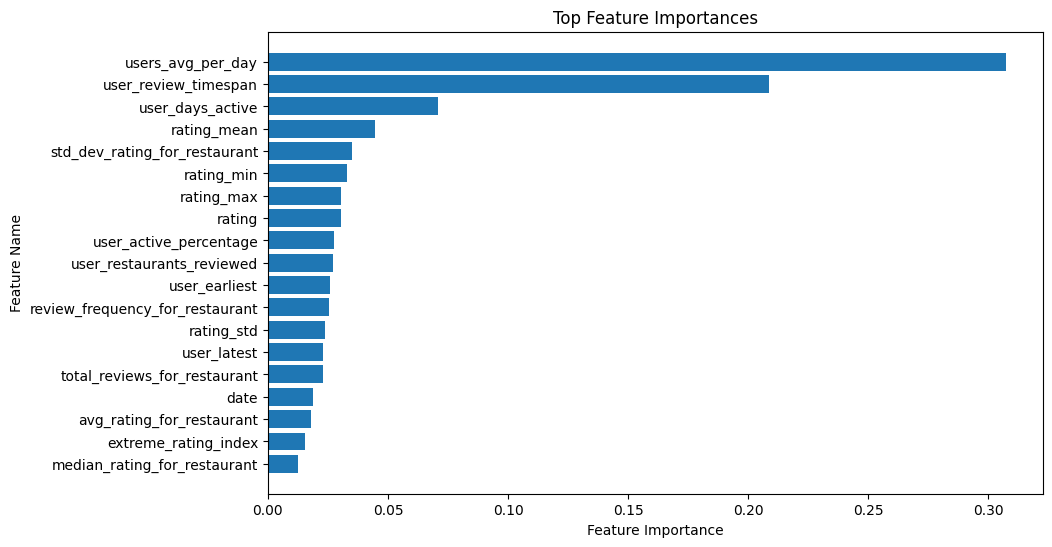

,Feature,Importance
17,users_avg_per_day,0.307306
16,user_review_timespan,0.208558
15,user_days_active,0.070689
9,rating_mean,0.044704
4,std_dev_rating_for_restaurant,0.035050
10,rating_min,0.033010
11,rating_max,0.030480
0,rating,0.030383
18,user_active_percentage,0.027449
8,user_restaurants_reviewed,0.027199


In [36]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Train XGBoost model
xgclf = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
xgclf.fit(new_X_train, y_train)

# Get feature importance
feature_importance = xgclf.feature_importances_
feature_names = new_X_train.columns

# Convert to DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:20], feat_imp_df['Importance'][:20])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Display the top features
feat_imp_df.head(20)

In [30]:
# checking versions (sync with kaggle if using)
import sys
import numpy as np
import pandas as pd
import sklearn

print("Python Version:", sys.version)
print("NumPy Version:", np.__version__)
print("Pandas Version:", pd.__version__)
print("Scikit-Learn Version:", sklearn.__version__)

Python Version: 3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
NumPy Version: 1.26.3
Pandas Version: 2.2.1
Scikit-Learn Version: 1.5.0
